# Integration of CITE-seq and scRNA-seq data

Here we demonstrate how to integrate CITE-seq and scRNA-seq datasets with totalVI. The same principles here can be used to integrate CITE-seq datasets with different sets of measured proteins.


In [1]:
import sys

#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]


     |████████████████████████████████| 61kB 1.9MB/s 
ERROR: nbclient 0.5.0 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 122kB 11.7MB/s 
     |████████████████████████████████| 112kB 11.4MB/s 
     |████████████████████████████████| 8.7MB 5.3MB/s 
     |████████████████████████████████| 3.2MB 72.1MB/s 
     |████████████████████████████████| 2.4MB 68.6MB/s 
     |████████████████████████████████| 7.7MB 15.0MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 112kB 64.1MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 


## Imports and data loading

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9

import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

In [3]:
adata = scvi.data.pbmcs_10x_cite_seq(run_setup_anndata=False)

INFO      Downloading file at data/pbmc_10k_protein_v3.h5ad                     
Downloading...: 24938it [00:00, 34828.85it/s]                             
INFO      Downloading file at data/pbmc_5k_protein_v3.h5ad                      
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 36564.20it/s]


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

index
AAACCCAAGATTGTGA-1    PBMC10k
AAACCCACATCGGTTA-1    PBMC10k
AAACCCAGTACCGCGT-1    PBMC10k
AAACCCAGTATCGAAA-1    PBMC10k
AAACCCAGTCGTCATA-1    PBMC10k
                       ...   
TTTGGTTGTACGAGTG-1     PBMC5k
TTTGTTGAGTTAACAG-1     PBMC5k
TTTGTTGCAGCACAAG-1     PBMC5k
TTTGTTGCAGTCTTCC-1     PBMC5k
TTTGTTGCATTGCCGG-1     PBMC5k
Name: batch, Length: 10849, dtype: object

Now we hold-out the proteins of the 5k dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [5]:
held_out_proteins = adata.obsm["protein_expression"][batch == "PBMC5k"].copy()
adata.obsm["protein_expression"].loc[batch == "PBMC5k"] = np.zeros_like(adata.obsm["protein_expression"][batch == "PBMC5k"])

In [6]:
sc.pp.highly_variable_genes(
    adata, 
    batch_key="batch",
    flavor="seurat_v3",
    n_top_genes=4000, 
    subset=True
)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


<div class="alert alert-info">

Important

scvi-tools will automatically detect proteins as missing in a certain batch if the protein has 0 counts for each cell in the batch. In other words, to indicate a protein is missing in a certain batch, please set it to 0 for each cell.

</div>

In [7]:
scvi.data.setup_anndata(adata, batch_key="batch", protein_expression_obsm_key="protein_expression")

INFO      Using batches from adata.obs["batch"]                                 
INFO      No label_key inputted, assuming all cells have same label             
INFO      Using data from adata.X                                               
INFO      Computing library size prior per batch                                


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


INFO      Using protein expression from adata.obsm['protein_expression']        
INFO      Using protein names from columns of adata.obsm['protein_expression']  
INFO      Found batches with missing protein expression                         
INFO      Successfully registered anndata object containing 10849 cells, 4000   
          vars, 2 batches, 1 labels, and 14 proteins. Also registered 0 extra   
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Prepare and run model

In [8]:
vae = scvi.model.TOTALVI(
    adata, 
    latent_distribution="normal", 
    n_layers_decoder=2
)

In [9]:
vae.train()

INFO      Training for 400 epochs.                                              
INFO      KL warmup for 8136.75 iterations                                      
Training...: 100%|██████████| 400/400 [07:46<00:00,  1.17s/it]
INFO      Training time:  444 s. / 400 epochs                                   


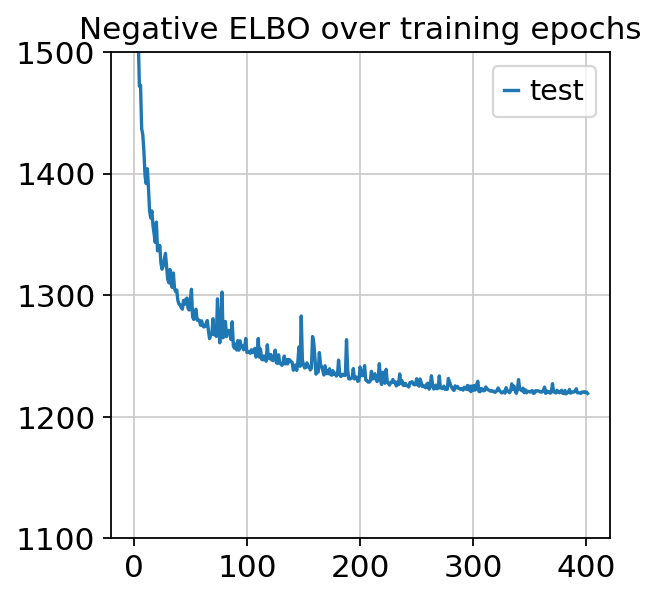

In [10]:
plt.plot(vae.trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

## Analyze outputs

Again, we rely on Scanpy.

In [11]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()
adata.obsm["protein_fg_prob"] = vae.get_protein_foreground_probability(transform_batch="PBMC10k")

rna, protein = vae.get_normalized_expression(transform_batch="PBMC10k", n_samples=25, return_mean=True)

<div class="alert alert-info">

Note

`transform_batch` is a power parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we've observed protein expression in batch "PBMC10k" (batch categories from original adata object), but we have no protein expression in batch "PBMC5k". We'd like to take the cells of batch "PBMC5k" and make a counterfactual prediction: "What would the expression look like if my batch "PBMC5k" cells came from batch "PBMC10k"?"

</div>

In [12]:
protein.iloc[:5, :5]

CD3_TotalSeqB  ...  CD15_TotalSeqB
index                              ...                
AAACCCAAGATTGTGA-1      11.983038  ...       14.570082
AAACCCACATCGGTTA-1      26.050329  ...        0.834571
AAACCCAGTACCGCGT-1       6.193423  ...        5.442019
AAACCCAGTATCGAAA-1      11.704298  ...      318.355438
AAACCCAGTCGTCATA-1       1.184370  ...        0.467108

[5 rows x 5 columns]

<div class="alert alert-info">

Note

The following is for illustrative purposes. In the code blocks above, we have the denoised protein values for each cell. These values have the expected protein background component removed. However, to compare to the held out protein values, we must include both protein foreground and background. We recommend using the values above for downstream tasks.

</div>

In [13]:
_, protein_means = vae.get_normalized_expression(
    n_samples=25, 
    transform_batch="PBMC10k",
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

In [14]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'batch' as categorical


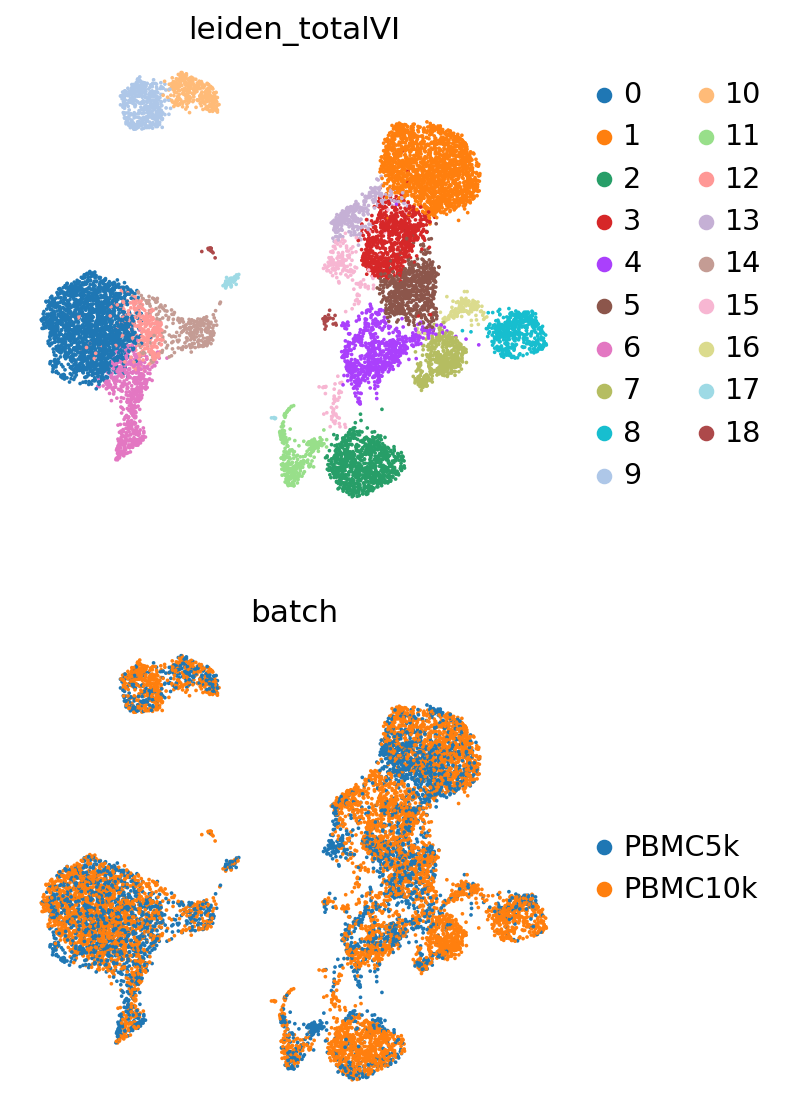

In [15]:
perm_inds = np.random.permutation(len(adata))
sc.pl.umap(
    adata[perm_inds], 
    color=["leiden_totalVI", "batch"],
    ncols=1,
    frameon=False,
)

In [16]:
batch = adata.obs.batch.values.ravel()
combined_protein = np.concatenate([adata.obsm["protein_expression"].values[batch=="PBMC10k"], held_out_proteins], axis=0)

# cleaner protein names
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
for i, p in enumerate(parsed_protein_names):
    adata.obs["{} imputed".format(p)] = protein_means.iloc[:, i]
    adata.obs["{} observed".format(p)] = combined_protein[:, i]

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


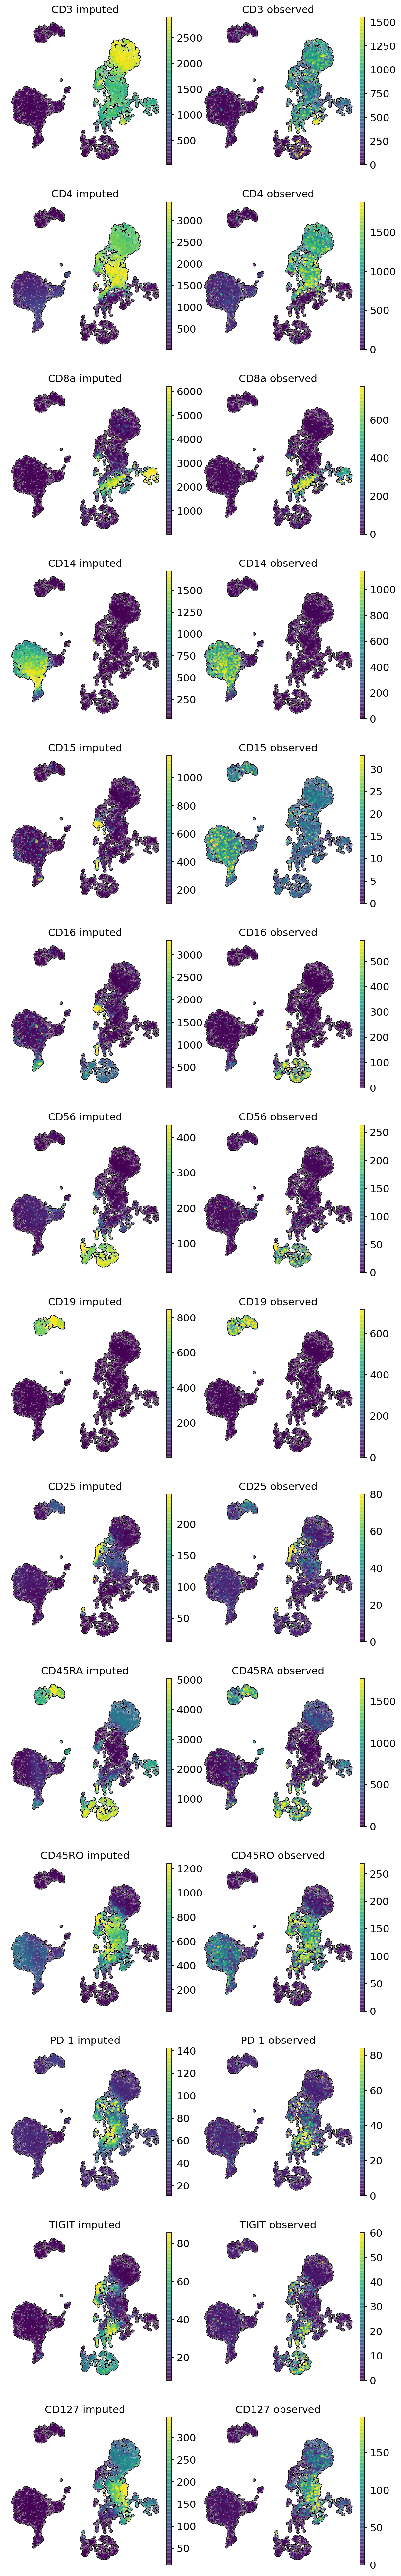

In [17]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    adata[adata.obs.batch == "PBMC5k"],
    color=viz_keys,
    ncols=2,
    vmax="p99",
    frameon=False,
    add_outline=True,
    wspace=0.1
)

## Imputed vs denoised correlations

In [18]:
from scipy.stats import pearsonr
imputed_pros = protein_means[batch == "PBMC5k"]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.to_numpy().ravel())
protein_names_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(parsed_protein_names[i] + ": Corr=" + str(np.round(pearsonr(held_out_proteins.values[:, i], imputed_pros.iloc[:, i])[0], 3)))
held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

Observed (log)  Imputed (log)           Protein
0        3.258097       3.497949   CD3: Corr=0.771
1        5.105945       6.003877   CD4: Corr=0.874
2        2.833213       3.468407  CD8a: Corr=0.809
3        6.546785       7.227176  CD14: Corr=0.907
4        2.995732       4.729743  CD15: Corr=0.029

We notice that CD15 has a really low correlation (imputation accuracy). Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

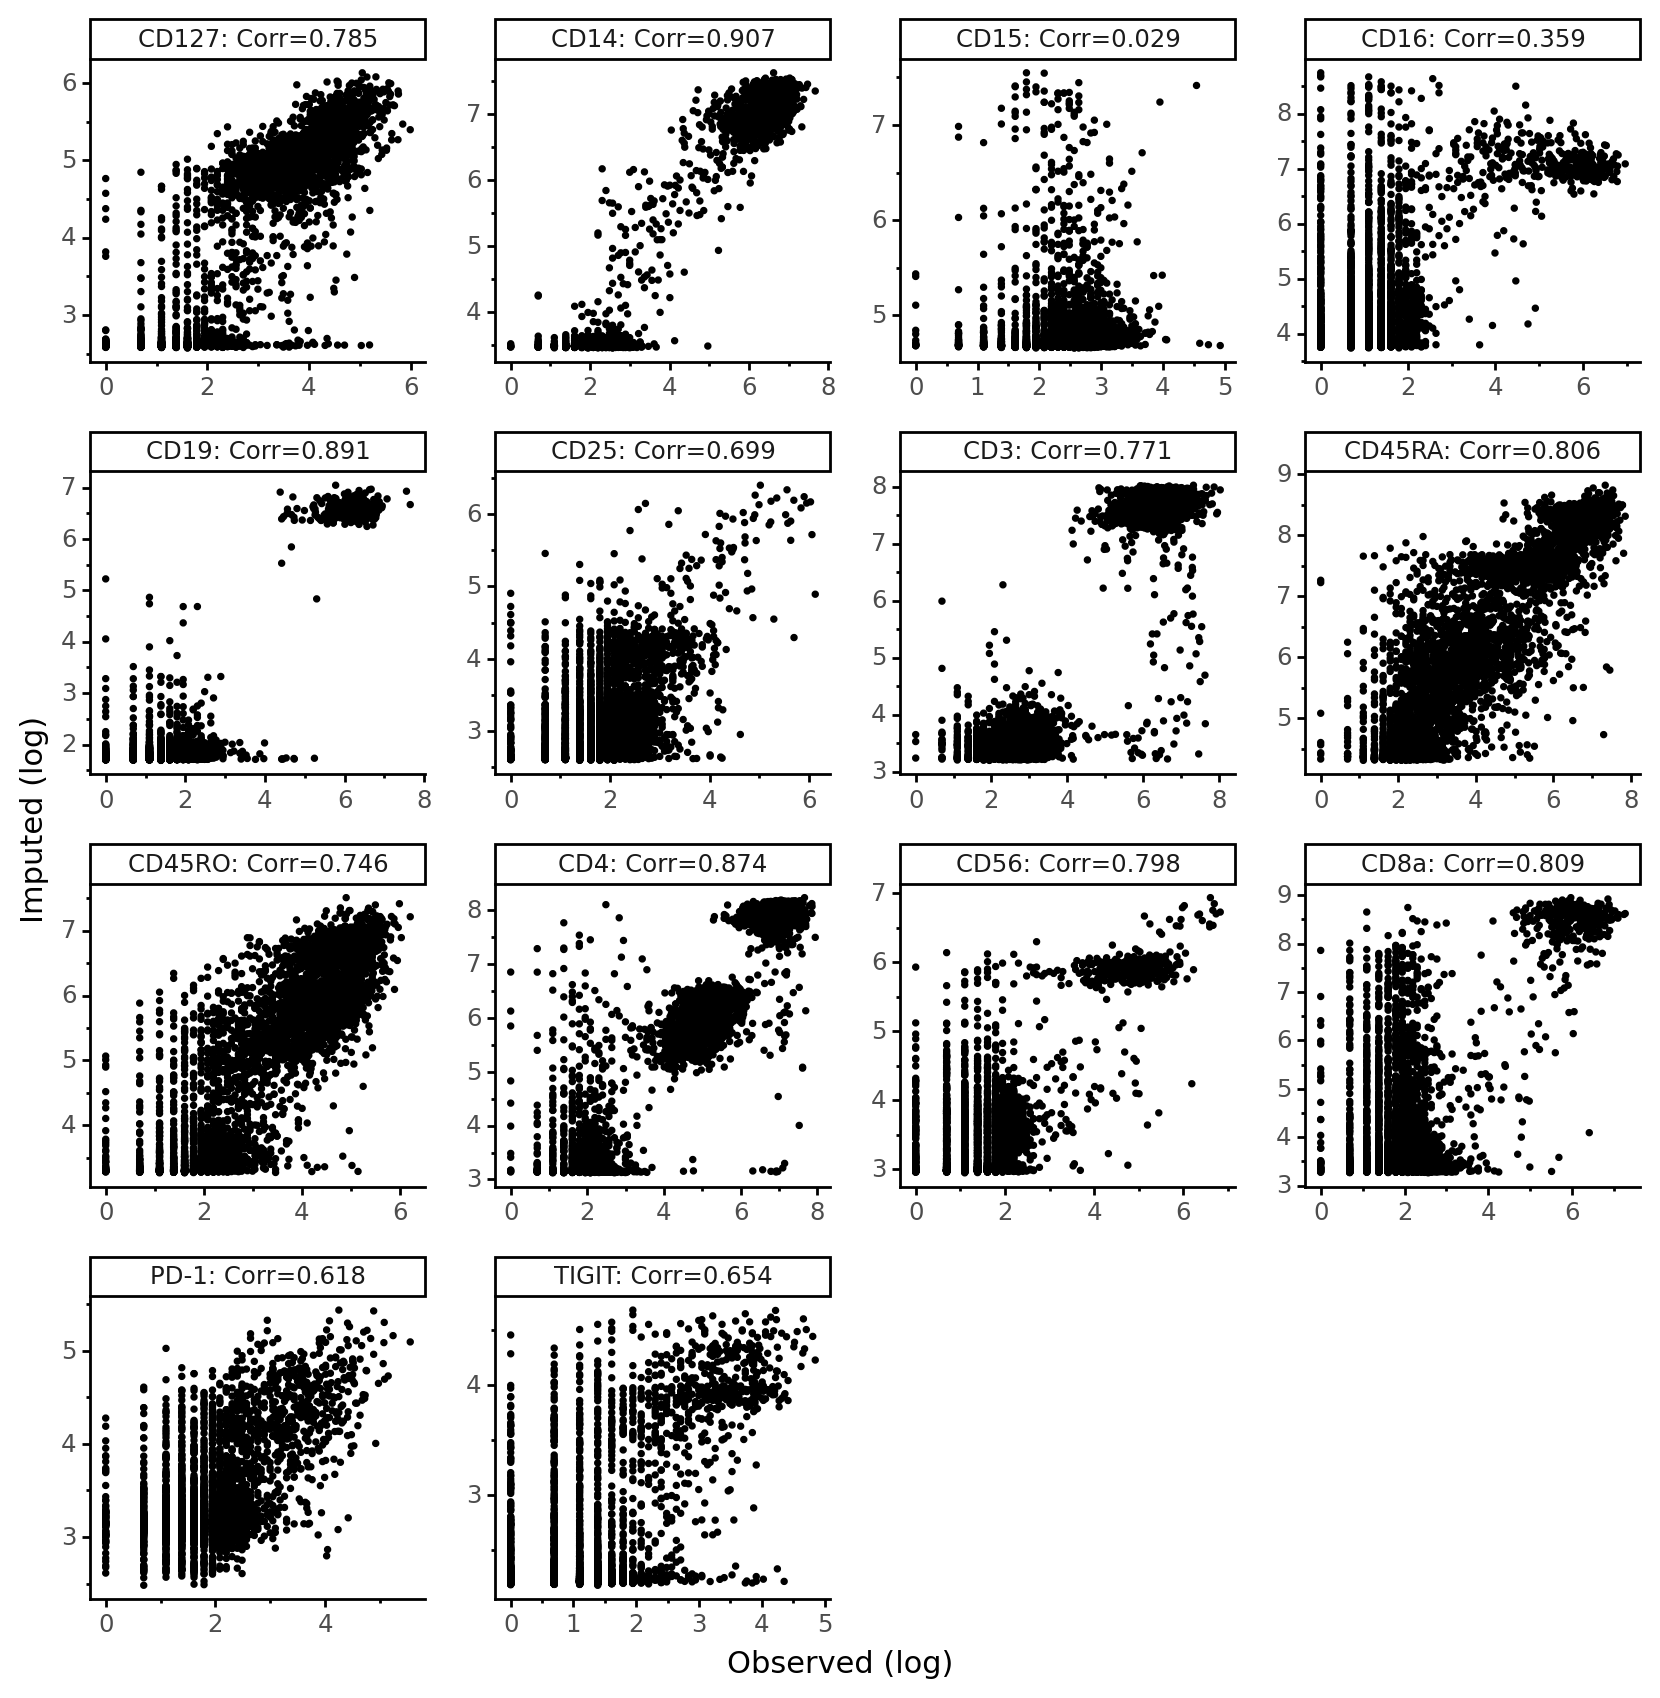

<ggplot: (8784187220572)>

In [19]:
p9.theme_set(p9.theme_classic)
(p9.ggplot(held_vs_denoised, p9.aes("Observed (log)", "Imputed (log)"))
 + p9.geom_point(size=0.5)
 + p9.facet_wrap("~Protein", scales="free")
 + p9.theme(figure_size=(10, 10), panel_spacing=.35,)
)
